In [1]:
! pip install -q optax equinox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 5.9 MB/s eta 0:00:00


In [2]:
import jax.numpy as jnp
import equinox as eqx
import optax
import time

from jax import config, random, vmap
from jax.tree_util import tree_map, tree_flatten
from jax.lax import dot_general, scan
from jax.nn import gelu

import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

# Dilated Resisdual Network

A netowrk is a combination of several well-known ideas:

1. Residual connections help training https://arxiv.org/abs/1512.03385
2. Dilated convolutions increase receptive field https://arxiv.org/abs/1511.07122

This network was applied in https://arxiv.org/abs/1511.07122 to speed up simulation of turbulence.

The structure of the network is pretty simple:

1. Encoder that increases the number of features
2. Processor is a composition of convolution blocks with dilations joined by skip connection.

   More specifically, in the present architecture we use $7$ convolutions with dilations $[1, 2, 4, 8, 4, 2, 1]$ and $\text{gelu}$ activations between them. The sizes of kernels are the same.

3. Decoder that decreases the number of features


This is implemented below.

In [3]:
def normalize_conv(A):
    A = eqx.tree_at(lambda x: x.weight, A, A.weight*jnp.sqrt(2/A.weight.shape[1]))
    A = eqx.tree_at(lambda x: x.bias, A, jnp.zeros_like(A.bias))
    return A

class DilatedConvBlock(eqx.Module):
    convolutions: list

    def __init__(self, channels, dilations_D, kernel_sizes_D, key):
        # 1D example: channels = [3, 40, 40, 1], dilations_D = [[1,], [1,], [1]], kernel_sizes_D = [[3,], [3,], [3,]]
        # 2D example: channels = [3, 40, 40, 1], dilations_D = [[4, 4], [3, 3], [2, 1]], kernel_sizes_D = [[3, 4], [3, 4], [4, 5]]
        kernel_sizes_D = [[k if k%2 == 1 else k+1 for k in kernel_sizes] for kernel_sizes in kernel_sizes_D]
        paddings_D = [[d*(k//2) for d, k in zip(dilations, kernel_sizes)] for dilations, kernel_sizes in zip(dilations_D, kernel_sizes_D)]
        keys = random.split(key, len(channels))
        D = len(kernel_sizes_D[0])
        self.convolutions = [normalize_conv(eqx.nn.Conv(num_spatial_dims=D, in_channels=f_i, out_channels=f_o, dilation=d, kernel_size=k, padding=p, key=key)) for f_i, f_o, d, k, p, key in zip(channels[:-1], channels[1:], dilations_D, kernel_sizes_D, paddings_D, keys)]

    def __call__(self, x):
        for conv in self.convolutions[:-1]:
            x = gelu(conv(x))
        x = self.convolutions[-1](x)
        return x

class DilResNet(eqx.Module):
    encoder: eqx.Module
    decoder: eqx.Module
    processor: list

    def __init__(self, key, channels, n_cells, kernel_size=3, D=1):
        in_channels, processor_channels, out_channels = channels
        keys = random.split(key, 3)
        self.encoder = DilatedConvBlock([in_channels, processor_channels], [[1,]*D,], [[kernel_size,]*D,], keys[0])
        self.decoder = DilatedConvBlock([processor_channels, out_channels], [[1,]*D,], [[kernel_size,]*D,], keys[1])
        keys = random.split(keys[2], n_cells)
        channels_ = [processor_channels,]*8
        dilations = [[1,]*D, [2,]*D, [4,]*D, [8,]*D, [4,]*D, [2,]*D, [1,]*D]
        kernel_sizes = [[kernel_size,]*D,]*7
        self.processor = [DilatedConvBlock(channels_, dilations, kernel_sizes, key) for key in keys]

    def __call__(self, u, x):
        u = jnp.concatenate([x, u], 0)
        u = self.encoder(u)
        for pr in self.processor:
            u = gelu(pr(u)) + u
        u = self.decoder(u)
        return u

def compute_loss(model, features, coordinates, targets):
    prediction = vmap(model, in_axes=(0, None))(features, coordinates)
    mean_error = jnp.mean(jnp.linalg.norm((prediction - targets).reshape(prediction.shape[0], -1), axis=1))
    return mean_error

compute_loss_and_grads = eqx.filter_value_and_grad(compute_loss)

def make_step(carry, n, optim):
    model, features, coordinates, targets, opt_state = carry
    loss, grads = compute_loss_and_grads(model, features[n], coordinates, targets[n])
    grads = tree_map(lambda x: x.conj(), grads)
    updates, opt_state = optim.update(grads, opt_state, eqx.filter(model, eqx.is_array))
    model = eqx.apply_updates(model, updates)
    return [model, features, coordinates, targets, opt_state], loss

def compute_relative_error(model, features, targets, n):
    prediction = vmap(model, in_axes=(0, None))(features[n], coordinates)
    relative_error = jnp.linalg.norm((prediction - targets[n]).reshape(n.size, -1), axis=1) / jnp.linalg.norm(targets[n].reshape(n.size, -1), axis=1)
    return relative_error

# KdV D=1

In [4]:
def s(x, t, c):
    return c/jnp.cosh(jnp.sqrt(c)*((x-c*t)%1.0-0.5)/2)**2/2

def get_dataset_KdV_1D(key=random.PRNGKey(11), N_samples=1000, c_min = 500, c_max = 900, delta_t = 0.3*1/700, N_x=100, normalize=False):
    x = jnp.linspace(0, 1, N_x)
    keys = random.split(key)
    c = c_min + (c_max - c_min) * random.uniform(keys[0], (N_samples,))
    x0 = random.uniform(keys[1], (N_samples,))
    t0 = x0 / c
    t1 = t0 + delta_t
    features = vmap(s, in_axes=(None, 0, 0))(x, t0, c)
    targets = vmap(s, in_axes=(None, 0, 0))(x, t1, c)
    features = jnp.expand_dims(features, 1)
    targets = jnp.expand_dims(targets, 1)

    if normalize:
        features_scale = jnp.max(jnp.abs(features), axis=[0, 2], keepdims=True)
        targets_scale = jnp.max(jnp.abs(targets), axis=[0, 2], keepdims=True)
        features = features / features_scale
        targets = targets / targets_scale

    return features, targets, jnp.expand_dims(x, 0)

dataset generation time: 1.271 s
Shapes of features, targets and coordinates: (1000, 1, 100) (1000, 1, 100) (1, 100)
model size: 9445
training time: 50.42171 s
train error 0.04782199114561081, test error 0.05018321052193642


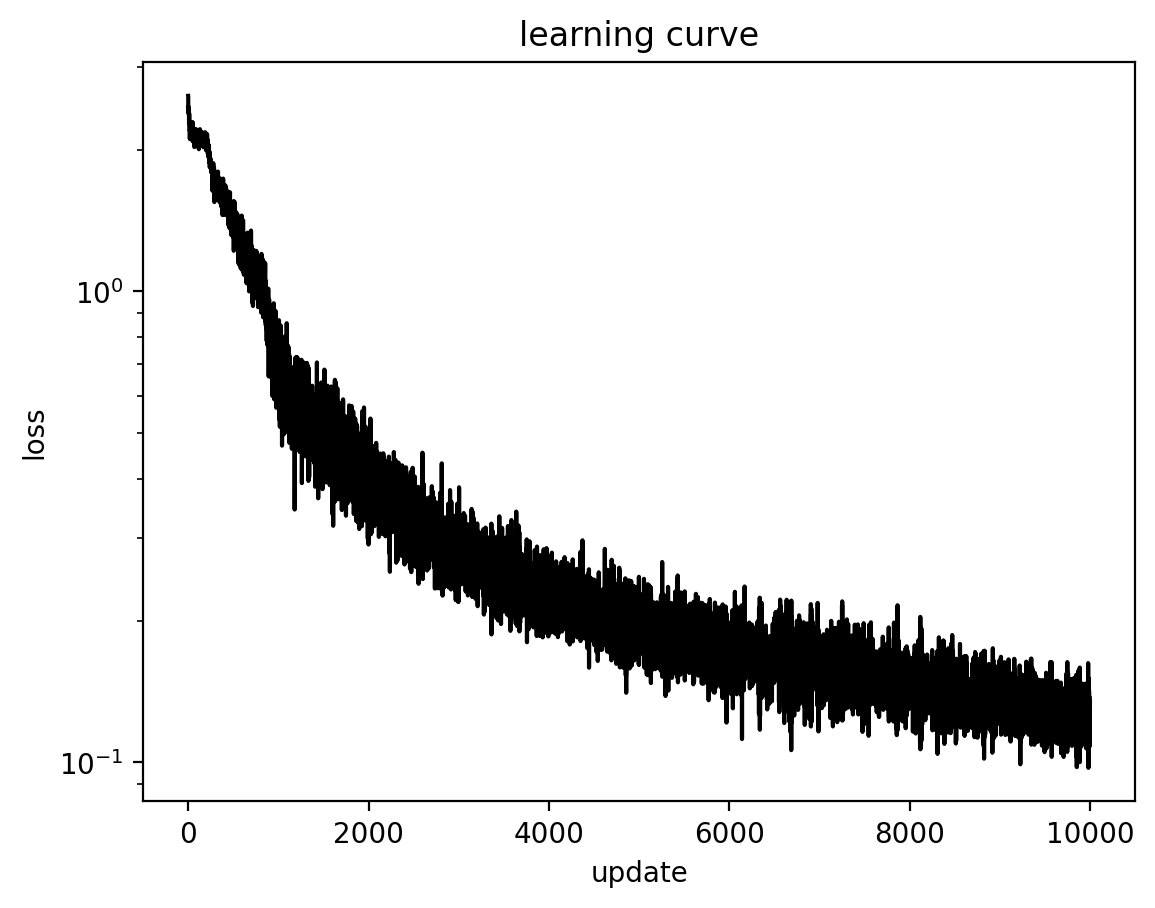

In [5]:
# generate dataset
N_samples = 1000
key = random.PRNGKey(11)
start = time.time()
features, targets, coordinates = get_dataset_KdV_1D(key=key, N_samples=N_samples, normalize=True)
stop = time.time()
print("dataset generation time:", round(stop - start, ndigits=5), "s")

print("Shapes of features, targets and coordinates:", features.shape, targets.shape, coordinates.shape)

# define model
n_cells = 3
channels = [coordinates.shape[0] + features.shape[1], 12, 1]
key = random.PRNGKey(11)
model = DilResNet(key, channels, n_cells)
model_size = sum(tree_map(jnp.size, tree_flatten(model)[0], is_leaf=eqx.is_array))
print("model size:", model_size)

# define optimizer
learning_rate = 5e-4
optim = optax.lion(learning_rate=learning_rate)
opt_state = optim.init(eqx.filter(model, eqx.is_array))

# specify training loop parameters
N_batch = 50
N_run = 10000
N_train = 800
key = random.PRNGKey(11)
ind = random.choice(key, N_train, (N_run, N_batch))
make_step_scan = lambda a, b: make_step(a, b, optim)
carry = [model, features, coordinates, targets, opt_state]

# training
start = time.time()
carry, history = scan(make_step_scan, carry, ind)
stop = time.time()
model = carry[0]
print("training time:", round(stop - start, ndigits=5), "s")

# evaluation
ind = jnp.arange(features.shape[0]).reshape(-1, N_batch)
compute_error = lambda a, x: (None, compute_relative_error(model, features, targets, x))
_, errors = scan(compute_error, None, ind)
errors = errors.reshape(-1,)
train_error = errors[:N_train]
test_error = errors[N_train:]

print(f"train error {jnp.mean(train_error)}, test error {jnp.mean(test_error)}")

plt.yscale("log")
plt.plot(history, color="black")
plt.title("learning curve")
plt.ylabel("loss")
plt.xlabel("update");

# Elliptic D=1

In [6]:
def get_coordinates(N):
    x = jnp.linspace(0, 1, N+2)[1:]
    h = x[1] - x[0]
    x_half = x - h/2
    return x_half, x[:-1]

def get_matrix(sigma_half):
    A = jnp.diag(sigma_half[:-1] + sigma_half[1:]) - jnp.diag(sigma_half[1:-1], k=-1) - jnp.diag(sigma_half[1:-1], k=1)
    return A

def get_matrices(x, N, p, l):
    return jnp.stack([jnp.exp(1j*x*2*jnp.pi*k) / (1 + (2*jnp.pi*k / l)**2)**p for k in range(N)], 1)

def get_diffusion_coefficient(key, M, s):
    coeff = random.normal(key, (M.shape[1],), dtype=jnp.complex64)
    sigma = jnp.real(M @ coeff)
    sigma = s*(sigma - jnp.min(sigma)) / (jnp.max(sigma) - jnp.min(sigma)) + 1
    return sigma

def piecewise_linear_diffusion_coefficient(key, x, s, k):
    keys = random.split(key)
    vals = random.uniform(keys[0], (k,), minval=1, maxval=s)
    coords = random.uniform(keys[1], (k,))
    coords = coords.at[0].set(0)
    coords = coords.at[-1].set(1)
    return jnp.interp(x, coords, vals)

def get_data(key, N_samples, constant_rhs=False, laplace=False, N = 100, s=4):
    M = 150
    p = 2
    l = 10
    k = 5
    x_half, x = get_coordinates(N)
    h = x[1] - x[0]
    T = get_matrices(x_half, M, p, l)
    T_x = get_matrices(x, M, p, l)
    keys = random.split(key, N_samples)

    features = []
    targets = []
    Matrices = []
    for key in keys:
        key1, key2 = random.split(key)
        if laplace:
            sigma = jnp.ones_like(x_half)
        else:
            sigma = get_diffusion_coefficient(key1, T, s)
        A = get_matrix(sigma)

        if constant_rhs:
            b = jnp.ones((N,))
        else:
            coeff = random.normal(key2, (T_x.shape[1],), dtype=jnp.complex64)
            b = jnp.real(T_x @ coeff)
        b = h**2 * b
        sol = jnp.linalg.solve(A, b)
        sigma = get_diffusion_coefficient(key1, T_x, s)
        if laplace:
            sigma = jnp.ones_like(x)
        features.append(jnp.stack([sigma, b/h**2]))
        targets.append(sol)
    features = jnp.stack(features, 0)
    targets = jnp.expand_dims(jnp.stack(targets, 0), 1)
    return features, targets, jnp.expand_dims(x, 0)

def get_dataset_elliptic_1D(name, N_samples=1000, key=random.PRNGKey(33), N=100, s=4, normalize=False):
    if name == "Dataset 1":
        features, targets, coordinates = get_data(key, N_samples, constant_rhs=False, laplace=False, N=N, s=s)
    elif name == "Dataset 2":
        features, targets, coordinates = get_data(key, N_samples, constant_rhs=True, laplace=False, N=N, s=s)
    else:
        features, targets, coordinates = get_data(key, N_samples, constant_rhs=False, laplace=True, N=N, s=s)

    if normalize:
        features_scale = jnp.max(jnp.abs(features), axis=[0, 2], keepdims=True)
        targets_scale = jnp.max(jnp.abs(targets), axis=[0, 2], keepdims=True)
        features = features / features_scale
        targets = targets / targets_scale
    return features, targets, coordinates

dataset generation time: 9.97132 s
Shapes of features, targets and coordinates: (1000, 2, 100) (1000, 1, 100) (1, 100)
model size: 9481
training time: 51.44809 s
train error 0.0786142647266388, test error 0.08626928180456161


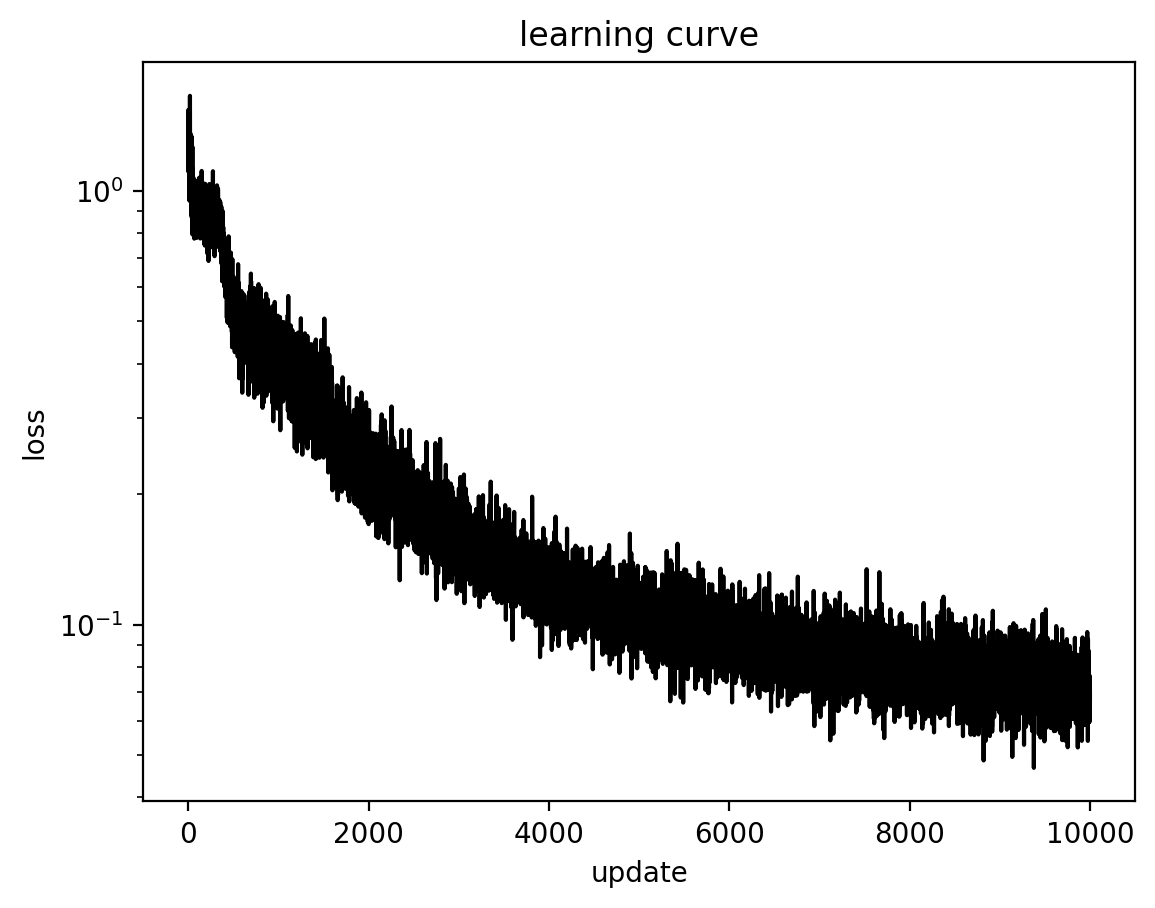

In [7]:
# generate dataset
N_samples = 1000
key = random.PRNGKey(11)
start = time.time()
features, targets, coordinates = get_dataset_elliptic_1D('Dataset 1', N_samples=N_samples, normalize=True)
stop = time.time()
print("dataset generation time:", round(stop - start, ndigits=5), "s")
print("Shapes of features, targets and coordinates:", features.shape, targets.shape, coordinates.shape)

# define model
n_cells = 3
channels = [coordinates.shape[0] + features.shape[1], 12, 1]
key = random.PRNGKey(11)
model = DilResNet(key, channels, n_cells)
model_size = sum(tree_map(jnp.size, tree_flatten(model)[0], is_leaf=eqx.is_array))
print("model size:", model_size)

# define optimizer
learning_rate = 5e-4
optim = optax.lion(learning_rate=learning_rate)
opt_state = optim.init(eqx.filter(model, eqx.is_array))

# specify training loop parameters
N_batch = 50
N_run = 10000
N_train = 800
key = random.PRNGKey(11)
ind = random.choice(key, N_train, (N_run, N_batch))
make_step_scan = lambda a, b: make_step(a, b, optim)
carry = [model, features, coordinates, targets, opt_state]

# training
start = time.time()
carry, history = scan(make_step_scan, carry, ind)
stop = time.time()
model = carry[0]
print("training time:", round(stop - start, ndigits=5), "s")

# evaluation
ind = jnp.arange(features.shape[0]).reshape(-1, N_batch)
compute_error = lambda a, x: (None, compute_relative_error(model, features, targets, x))
_, errors = scan(compute_error, None, ind)
errors = errors.reshape(-1,)
train_error = errors[:N_train]
test_error = errors[N_train:]

print(f"train error {jnp.mean(train_error)}, test error {jnp.mean(test_error)}")

plt.yscale("log")
plt.plot(history, color="black")
plt.title("learning curve")
plt.ylabel("loss")
plt.xlabel("update");

# KdV D=2

In [8]:
def s(x, t, c):
    return c/jnp.cosh(jnp.sqrt(c)*((x-c*t)%1.0-0.5)/2)**2/2

def get_dataset_KdV_2D(key=random.PRNGKey(11), N_samples=1000, c_min=500, c_max=900, delta_t=0.3*1/700, N_x=100, N_t=100, normalize=False):
    x = jnp.linspace(0, 1, N_x)
    keys = random.split(key)
    c = c_min + (c_max - c_min) * random.uniform(keys[0], (N_samples,))
    x0 = random.uniform(keys[1], (N_samples,))
    t0 = x0 / c
    t = delta_t * jnp.linspace(0, 1, N_t)
    X, T = jnp.meshgrid(x, t)
    coordinates = jnp.stack([X, T], 0)
    t = jnp.expand_dims(t, 0) + jnp.expand_dims(t0, 1)
    t = jnp.expand_dims(t, 2)
    x = jnp.expand_dims(x, 0)
    solutions = vmap(s, in_axes=(None, 0, 0))(x, t, c) # solutions.shape = (N_samples, N_t, N_x)

    features = solutions[:, :1, :]
    targets = jnp.expand_dims(solutions, 1)

    if normalize:
        features_scale = jnp.max(jnp.abs(features), axis=[0, 2], keepdims=True)
        targets_scale = jnp.max(jnp.abs(targets), axis=[0, 2, 3], keepdims=True)
        features = features / features_scale
        targets = targets / targets_scale

    return features, targets, coordinates

dataset generation time: 1.03676 s
Shapes of features, targets and coordinates: (1000, 1, 100, 100) (1000, 1, 100, 100) (2, 100, 100)
model size: 27913
training time: 203.13334 s
train error 0.1149616688489914, test error 0.12447115033864975


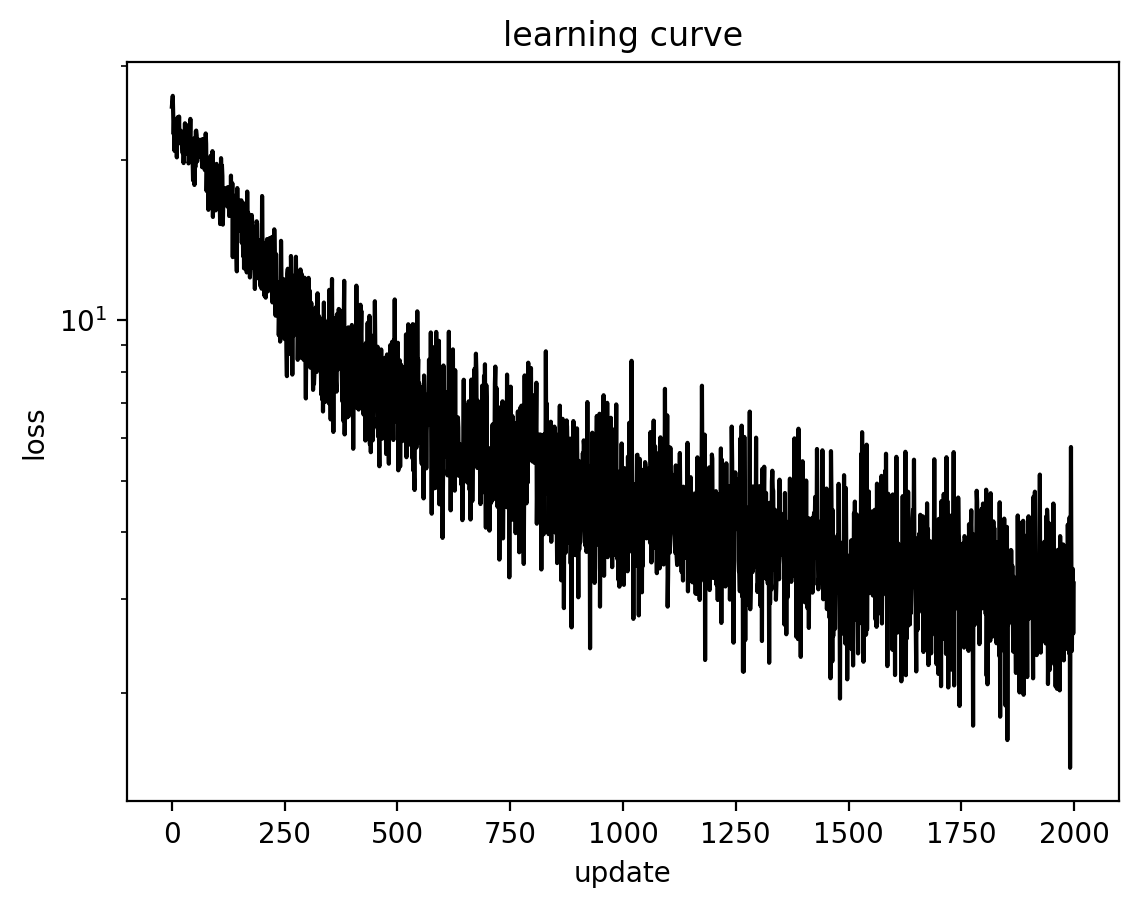

In [9]:
# generate dataset
N_samples = 1000
key = random.PRNGKey(11)
start = time.time()
features, targets, coordinates = get_dataset_KdV_2D(key=key, N_samples=N_samples, normalize=True)
stop = time.time()
print("dataset generation time:", round(stop - start, ndigits=5), "s")

# u_0(x) -> u_0(x, t) = u_0(x)
features = jnp.expand_dims(features, 2) + jnp.zeros_like(targets)

print("Shapes of features, targets and coordinates:", features.shape, targets.shape, coordinates.shape)

# define model
n_cells = 3
channels = [coordinates.shape[0] + features.shape[1], 12, 1]
key = random.PRNGKey(11)
model = DilResNet(key, channels, n_cells, D=2)
model_size = sum(tree_map(jnp.size, tree_flatten(model)[0], is_leaf=eqx.is_array))
print("model size:", model_size)

# define optimizer
learning_rate = 5e-4
optim = optax.lion(learning_rate=learning_rate)
opt_state = optim.init(eqx.filter(model, eqx.is_array))

# specify training loop parameters
N_batch = 10
N_run = 2000
N_train = 800
key = random.PRNGKey(11)
ind = random.choice(key, N_train, (N_run, N_batch))
make_step_scan = lambda a, b: make_step(a, b, optim)
carry = [model, features, coordinates, targets, opt_state]

# training
start = time.time()
carry, history = scan(make_step_scan, carry, ind)
stop = time.time()
model = carry[0]
print("training time:", round(stop - start, ndigits=5), "s")

# evaluation
ind = jnp.arange(features.shape[0]).reshape(-1, N_batch)
compute_error = lambda a, x: (None, compute_relative_error(model, features, targets, x))
_, errors = scan(compute_error, None, ind)
errors = errors.reshape(-1,)
train_error = errors[:N_train]
test_error = errors[N_train:]

print(f"train error {jnp.mean(train_error)}, test error {jnp.mean(test_error)}")

plt.yscale("log")
plt.plot(history, color="black")
plt.title("learning curve")
plt.ylabel("loss")
plt.xlabel("update");

# Elliptic D=2

Shapes of features, targets and coordinates: (1000, 2, 64, 64) (1000, 1, 64, 64) (2, 64, 64)
model size: 37177
training time: 210.44699 s
train error 0.1709359735250473, test error 0.1710805594921112


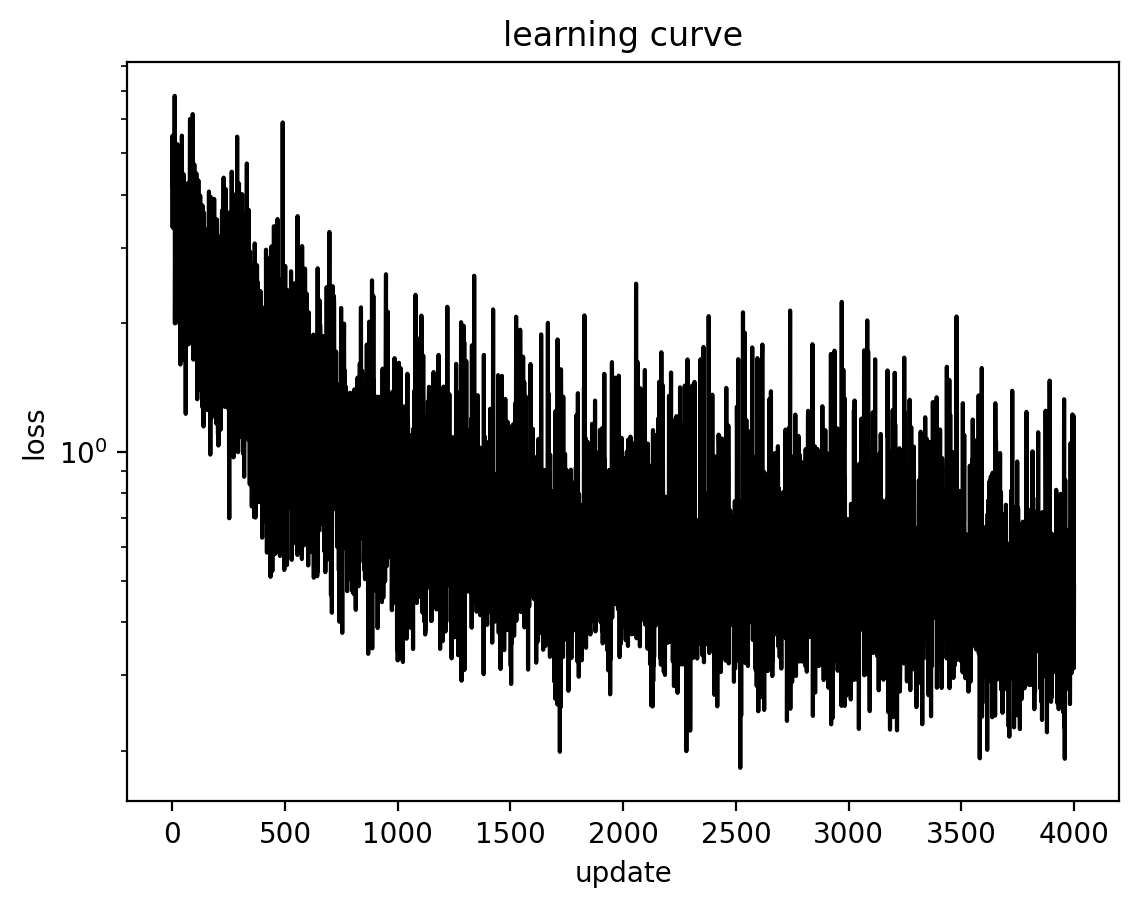

In [22]:
# # download dataset
# # in case this code fails, download using the link and upload to colab / mount your google drive
# base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
# public_key = 'https://disk.yandex.ru/d/fz9ghnFEDm90Qw' # public link

# final_url = base_url + urlencode(dict(public_key=public_key))
# response = requests.get(final_url)
# download_url = response.json()['href']

# download_response = requests.get(download_url)
# with open('Elliptic.npz', 'wb') as f:
#     f.write(download_response.content)

data = jnp.load('Elliptic.npz')
features, targets, coordinates = data["features"], data["targets"], data["coordinates"]

features_scale = jnp.max(jnp.abs(features), axis=[0, 2, 3], keepdims=True)
targets_scale = jnp.max(jnp.abs(targets), axis=[0, 2, 3], keepdims=True)
features = features / features_scale
targets = targets / targets_scale

print("Shapes of features, targets and coordinates:", features.shape, targets.shape, coordinates.shape)

# define model
n_cells = 4
channels = [coordinates.shape[0] + features.shape[1], 12, 1]
key = random.PRNGKey(11)
model = DilResNet(key, channels, n_cells, D=2)
model_size = sum(tree_map(jnp.size, tree_flatten(model)[0], is_leaf=eqx.is_array))
print("model size:", model_size)

# define optimizer
learning_rate = 5e-4
optim = optax.lion(learning_rate=learning_rate)
opt_state = optim.init(eqx.filter(model, eqx.is_array))

# specify training loop parameters
N_batch = 10
N_run = 4000
N_train = 800
key = random.PRNGKey(11)
ind = random.choice(key, N_train, (N_run, N_batch))
make_step_scan = lambda a, b: make_step(a, b, optim)
carry = [model, features, coordinates, targets, opt_state]

# training
start = time.time()
carry, history = scan(make_step_scan, carry, ind)
stop = time.time()
model = carry[0]
print("training time:", round(stop - start, ndigits=5), "s")

# evaluation
ind = jnp.arange(features.shape[0]).reshape(-1, N_batch)
compute_error = lambda a, x: (None, compute_relative_error(model, features, targets, x))
_, errors = scan(compute_error, None, ind)
errors = errors.reshape(-1,)
train_error = errors[:N_train]
test_error = errors[N_train:]

print(f"train error {jnp.mean(train_error)}, test error {jnp.mean(test_error)}")

plt.yscale("log")
plt.plot(history, color="black")
plt.title("learning curve")
plt.ylabel("loss")
plt.xlabel("update");

# Burgers D=1+1

Shapes of features, targets and coordinates: (1000, 1, 100, 100) (1000, 1, 100, 100) (2, 100, 100)
model size: 27913
training time: 202.08439 s
train error 0.17714853584766388, test error 0.19011151790618896


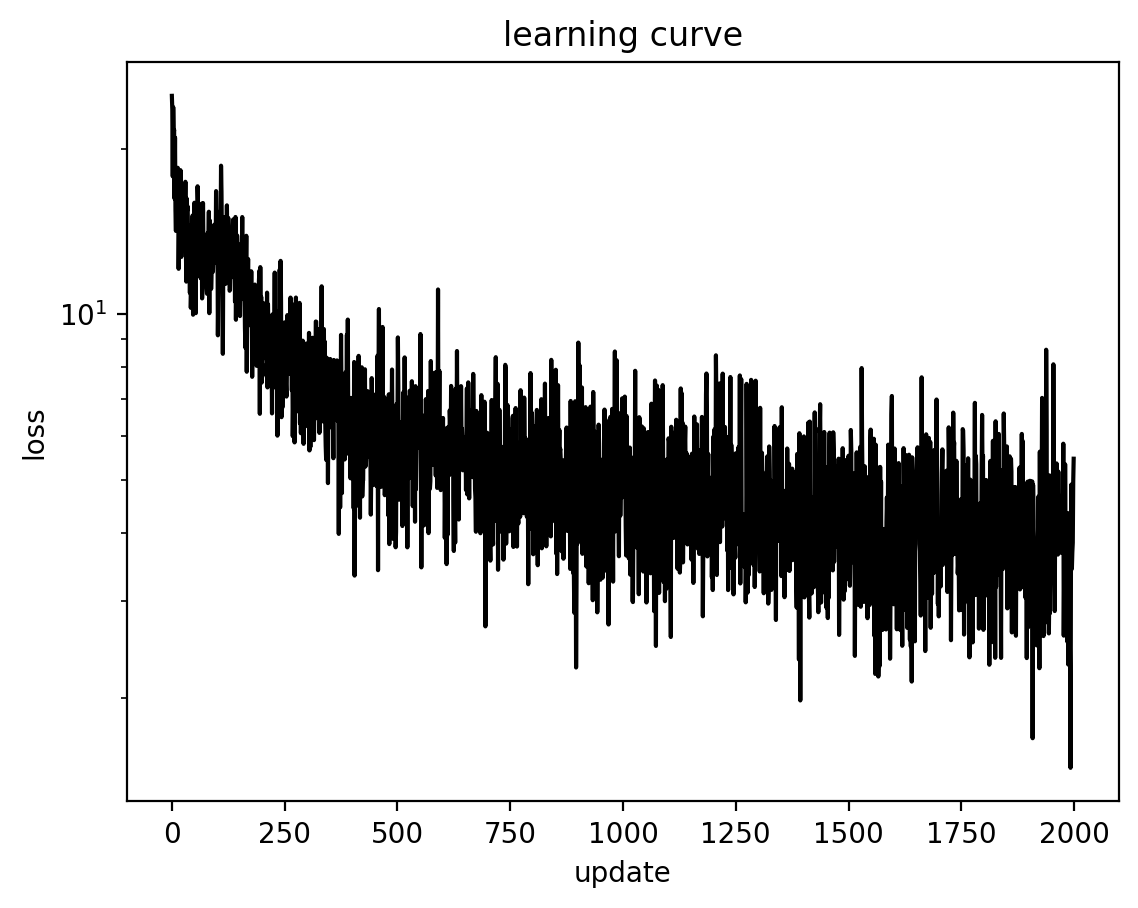

In [11]:
# # download dataset
# # in case this code fails, download using the link and upload to colab / mount your google drive
# base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
# public_key = 'https://disk.yandex.ru/d/kkcRqJYIIkRUgw' # public link

# final_url = base_url + urlencode(dict(public_key=public_key))
# response = requests.get(final_url)
# download_url = response.json()['href']

# download_response = requests.get(download_url)
# with open('Burgers.npz', 'wb') as f:
#     f.write(download_response.content)

data = jnp.load('Burgers.npz')
features, targets, coordinates = data["features"], data["targets"], data["coordinates"]

features_scale = jnp.max(jnp.abs(features), axis=[0, 2], keepdims=True)
targets_scale = jnp.max(jnp.abs(targets), axis=[0, 2, 3], keepdims=True)
features = features / features_scale
targets = targets / targets_scale

# u(x, t=0) -> u(x, t) = u(x, t=0), i.e., D=1 -> D=1+1
features = jnp.expand_dims(features, 2) + jnp.zeros_like(targets)

print("Shapes of features, targets and coordinates:", features.shape, targets.shape, coordinates.shape)

# define model
n_cells = 3
channels = [coordinates.shape[0] + features.shape[1], 12, 1]
key = random.PRNGKey(11)
model = DilResNet(key, channels, n_cells, D=2)
model_size = sum(tree_map(jnp.size, tree_flatten(model)[0], is_leaf=eqx.is_array))
print("model size:", model_size)

# define optimizer
learning_rate = 5e-4
optim = optax.lion(learning_rate=learning_rate)
opt_state = optim.init(eqx.filter(model, eqx.is_array))

# specify training loop parameters
N_batch = 10
N_run = 2000
N_train = 800
key = random.PRNGKey(11)
ind = random.choice(key, N_train, (N_run, N_batch))
make_step_scan = lambda a, b: make_step(a, b, optim)
carry = [model, features, coordinates, targets, opt_state]

# training
start = time.time()
carry, history = scan(make_step_scan, carry, ind)
stop = time.time()
model = carry[0]
print("training time:", round(stop - start, ndigits=5), "s")

# evaluation
ind = jnp.arange(features.shape[0]).reshape(-1, N_batch)
compute_error = lambda a, x: (None, compute_relative_error(model, features, targets, x))
_, errors = scan(compute_error, None, ind)
errors = errors.reshape(-1,)
train_error = errors[:N_train]
test_error = errors[N_train:]

print(f"train error {jnp.mean(train_error)}, test error {jnp.mean(test_error)}")

plt.yscale("log")
plt.plot(history, color="black")
plt.title("learning curve")
plt.ylabel("loss")
plt.xlabel("update");